# 왕관을 씌워볼까

## 데이터셋 전처리
### 데이터셋 확인

In [1]:
!cd ~/aiffel/GoingDeeper/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


### 내부 데이터셋 구조 확인

In [2]:
!cd ~/aiffel/GoingDeeper/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


* 이미지 파일 경로<br>
0--Parade/0_Parade_marchingband_1_849.jpg<br>
* face bounding box 개수<br>
1<br>
* face bounding box 좌표 등 상세정보<br>
x0,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; y0,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; w, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;h,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; blur, expression, illumination, invalid, occlusion, pose<br>
449 &nbsp;&nbsp;&nbsp;330&nbsp;&nbsp;&nbsp; 122 &nbsp;&nbsp;&nbsp;149&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 <br>

In [3]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt
import config as cf
import data_downloader as ddl
import dataset_parser as dp
import make_prior_box as mpb
import tf_build_ssd_model as tbsm
import tf_dataloader as tdl
import tf_dataset_preprocess as tdp

PROJECT_PATH = os.getenv('HOME')+'/aiffel/GoingDeeper/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')

DATASET_LEN = cf.cfg['dataset_len']
BATCH_SIZE = cf.cfg['batch_size']
IMAGE_WIDTH = cf.cfg['input_size'][1]
IMAGE_HEIGHT = cf.cfg['input_size'][0]
IMAGE_LABELS = cf.cfg["labels_list"]

100%|██████████| 3226/3226 [00:16<00:00, 196.20it/s]


### 이미지 프로세싱
* 이미지 관련 정보들을 정리

In [4]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(dp.parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = dp.process_image(image_file)
    boxes = dp.xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/GoingDeeper/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/GoingDeeper/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/GoingDeeper/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 2

## 데이터전처리 TFRecord
* 데이터 처리속도 향상을 위해서는 이진 레코드의 시퀀스로 저장하는 것이 유리
* 따라서 이진 레코드의 시퀀스를 가지는 Tensorflow만의 학습 데이터 저장 포맷인 TFRecord 데이터셋 형식으로 저장하기

In [5]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(dp.parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = dp.process_image(image_file)
            boxes = dp.xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = dp.make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:15<00:00, 213.84it/s]


## 모델 구현 Default boxes

In [6]:
# 위의 내용들을 함수화함.
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = cf.cfg['min_sizes']
    steps= cf.cfg['steps']
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

## 모델 구현 SSD

In [41]:
from tensorflow.keras.applications import MobileNetV2
def MobileNetV2_SSDModel():
    # anchor box의 수
    num_cells = [14,13,13,13,14]
    num_class = len(IMAGE_LABELS)
        
    inputs = tf.keras.layers.Input(shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3], name = 'input_image')
    
    # base model로 MobileNetV2사용해보기
    base_model = MobileNetV2(input_tensor = inputs, include_top = False, weights = None)
    base_model.load_weights('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    
    #MobileNetV2의 특정 레이어를 기준으로 feature map을 추출하기
    feature_map1 = base_model.get_layer('block_13_expand_relu').output
    feature_map2 = base_model.get_layer('block_16_project').output
    
    # 추가 레이어
    x1 = tbsm._conv_block(feature_map2, 512, strides=(2, 2), block_id=1)
    x2 = tbsm._depthwise_conv_block(x1, 256, strides=(2, 2), block_id=2)
    x3 = tbsm._depthwise_conv_block(x2, 256, strides=(2, 2), block_id=3)
    x4 = tbsm._depthwise_conv_block(x3, 128, strides=(2, 2), block_id=4)
    
    # extra_layers = [feature_map_1,feature_map_2, x1, x2, x3, x4]
    extra_layers = [feature_map1,x1, x2, x3, x4]

    confs = []
    locs = []
    
    for idx, layer in enumerate(extra_layers):
        conf, loc = tbsm._compute_heads(layer, idx, num_class, num_cells)
        confs.append(conf)
        locs.append(loc)
        

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [42]:
model = MobileNetV2_SSDModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  198
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 160, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 160, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 160, 32) 0           bn_Conv1[0][0]                   
_________________________________________________________

In [7]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = tbsm._conv_block(x, base_channel, strides=(2, 2))
    x = tbsm._conv_block(x, base_channel * 2, strides=(1, 1))
    x = tbsm._conv_block(x, base_channel * 2, strides=(2, 2))
    x = tbsm._conv_block(x, base_channel * 2, strides=(1, 1))
    x = tbsm._conv_block(x, base_channel * 4, strides=(2, 2))
    x = tbsm._conv_block(x, base_channel * 4, strides=(1, 1))
    x = tbsm._conv_block(x, base_channel * 4, strides=(1, 1))
    x = tbsm._conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = tbsm._branch_block(x, base_channel)

    x = tbsm._conv_block(x, base_channel * 8, strides=(2, 2))
    x = tbsm._conv_block(x, base_channel * 8, strides=(1, 1))
    x = tbsm._conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = tbsm._branch_block(x, base_channel)

    x = tbsm._depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = tbsm._depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = tbsm._branch_block(x, base_channel)

    x = tbsm._depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = tbsm._branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for idx, layer in enumerate(extra_layers):
        conf, loc = tbsm._compute_heads(layer, idx, num_class, num_cells)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [8]:
model2 = SsdModel()
print("the number of model layers: ", len(model2.layers))
model2.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

## 모델학습

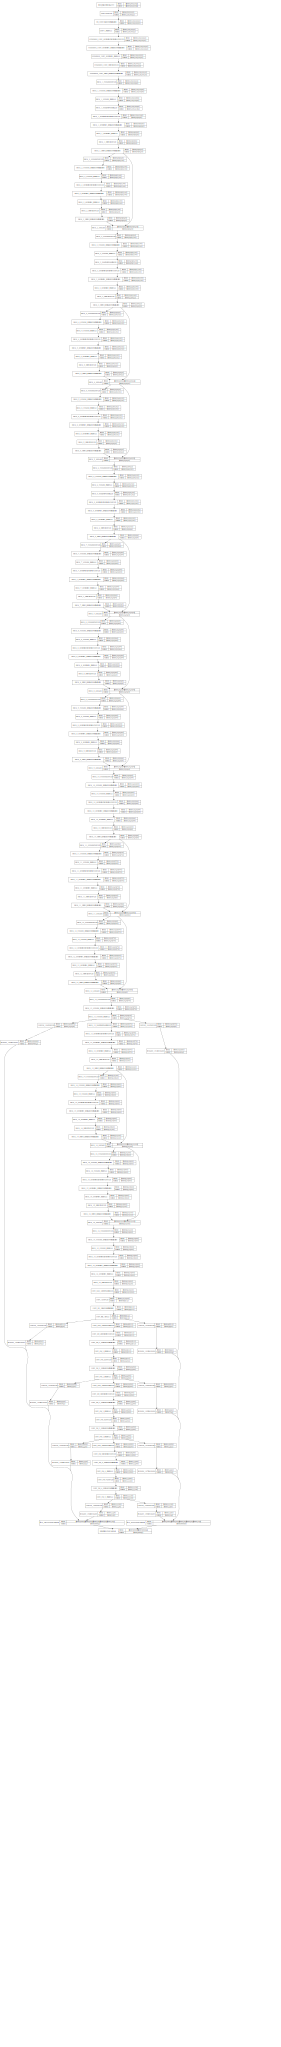

In [98]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Jupyter Notebook에 model 모델 시각화
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

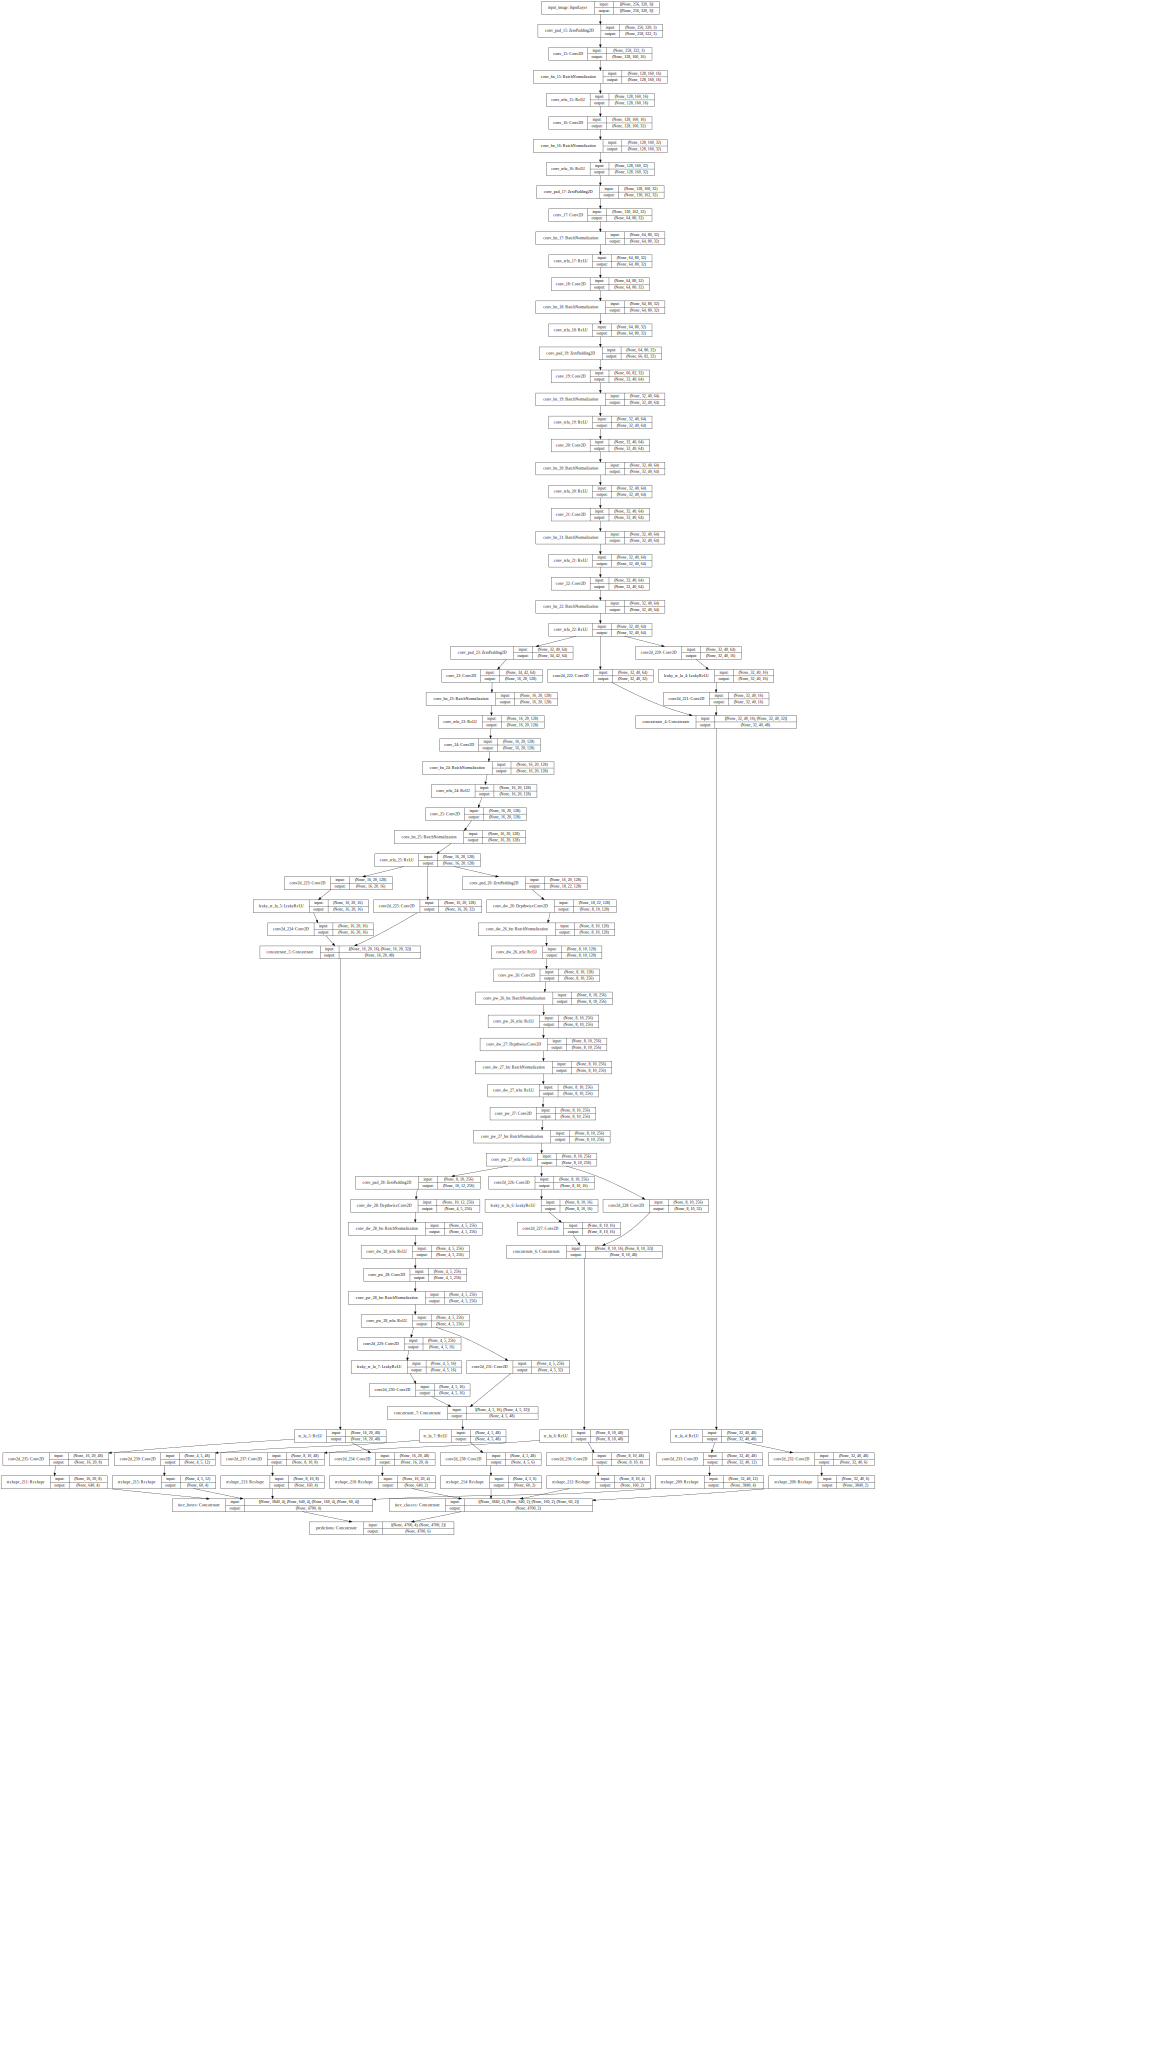

In [105]:
# Jupyter Notebook에 model2 모델 시각화
SVG(model_to_dot(model2, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [9]:
# Default box를 만들고 데이터셋 준비하기
boxes = default_box()
train_dataset = tdl.load_dataset(cf.cfg, priors = boxes, train=True)
val_dataset = tdl.load_dataset(cf.cfg, priors = boxes,train = False)

Image: (32, 256, 320, 3)
Label: (32, 4700, 5)
Image: (256, 320, 3)
Label: (4700, 5)
Label: [[149.8279    100.07121     9.022681    9.611595    0.       ]
 [ 93.64243    62.544506    6.672663    7.261577    0.       ]
 [ 62.428288   41.69634     4.645337    5.2342515   0.       ]
 ...
 [-10.482194   -9.369436   -3.724545   -3.1356304   0.       ]
 [ -6.9881296  -6.2462907  -5.7518706  -5.162956    0.       ]
 [ -5.241097   -4.684718   -7.1902804  -6.6013665   0.       ]]


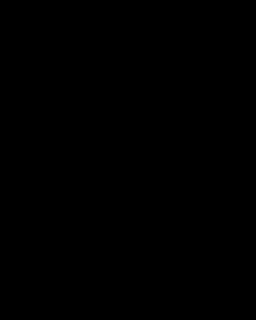

In [59]:
from PIL import Image
for image, label in train_dataset.take(1):
    print(f"Image: {image.shape}")
    print(f"Label: {label.shape}")
    for i in range(len(image)):
        img = image[i].numpy()
        lbl = label[i].numpy()
        print(f"Image: {img.shape}")
        print(f"Label: {lbl.shape}")
        print(f"Label: {lbl}")
        pil_img = Image.fromarray(img.transpose(1,0,2).astype(np.uint8))
        pil_img.show()
        break

In [10]:
import train_functions as trf
steps_per_epoch = DATASET_LEN // BATCH_SIZE
val_steps_epoch = cf.cfg['val_len'] // BATCH_SIZE
learning_rate = trf.MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = trf.MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

In [11]:
@tf.function
def train_step(model, inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [12]:
@tf.function
def validation_step(model, inputs, labels):
    predictions = model(inputs, training = False)
    losses = {}
    losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
    losses['loc'], losses['class'] = multi_loss(labels, predictions)
    total_loss = tf.add_n([l for l in losses.values()])
    return total_loss, losses

In [13]:
def calculate_accuracy(model,dataset):
    correct = 0
    total = 0
    for inputs, labels in train_dataset.take(steps_per_epoch):
        predictions = model(inputs, training = False)
        predicted_classes = tf.argmax(predictions[:,:, 4:], axis = -1)
        true_classes = tf.argmax(labels[:,:,4:], axis = -1)
        correct += tf.reduce_sum(tf.cast(predicted_class == true_classes, tf.float32)).numpy()
        total += tf.size(true_classes).numpy()
        
    accuracy = correct /total
    return accuracy

In [14]:
EPOCHS = 20

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(0, EPOCHS):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    # Training loop
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(model2, inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        train_loss += total_loss.numpy()
        
    train_loss /= DATASET_LEN
    
    # Validation loop
    for step,(inputs,labels) in enumerate(val_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = validation_step(model2, inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        val_loss += total_loss.numpy()
        
    val_loss /= cf.cfg['val_len']
    
    train_accuracy = calculate_accuracy(model2, train_dataset)
    val_accuracy = calculate_accuracy(model2, val_dataset)
    
    # Record history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


InvalidArgumentError: Reduction axis 0 is empty in shape [0,4700]
	 [[{{node ArgMax_1}}]] [Op:IteratorGetNext]

In [ ]:
EPOCHS = 20

history = {
    'loss': [],
    'loc_loss': [],
    'class_loss': []
}

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(model2, inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        history['loss'].append(total_loss)
        history['loc_loss'].append(losses['loc'])
        history['class_loss'].append(losses['class'])
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

In [43]:
EPOCHS = 20

history = {
    'loss': [],
    'loc_loss': [],
    'class_loss': []
}

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(model, inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        history['loss'].append(total_loss)
        history['loc_loss'].append(losses['loc'])
        history['class_loss'].append(losses['class'])
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

ValueError: in user code:

    /tmp/ipykernel_325/3518424926.py:7 train_step  *
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
    /aiffel/aiffel/GoingDeeper/face_detector/train_functions.py:77 multi_loss  *
        temp_loss = cross_entropy(class_truth, class_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__  **
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1738 sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:4956 sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:4351 sparse_softmax_cross_entropy_with_logits_v2
        return sparse_softmax_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:4256 sparse_softmax_cross_entropy_with_logits
        raise ValueError("Shape mismatch: The shape of labels (received %s) "

    ValueError: Shape mismatch: The shape of labels (received (32, 4700)) should equal the shape of logits except for the last dimension (received (32, 4858, 2)).


In [ ]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(12, 8))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]


In [19]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [22]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)


In [23]:
# 최종 box와 score결과를 만들어주기
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


In [24]:
# prediction
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores


In [25]:
# 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 
# 이미지 패딩 추가/제거해주는 함수
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params


In [26]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

In [27]:
# 최종 결과를 시각화하도록 이미지에 box를 그려주는 함수
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))


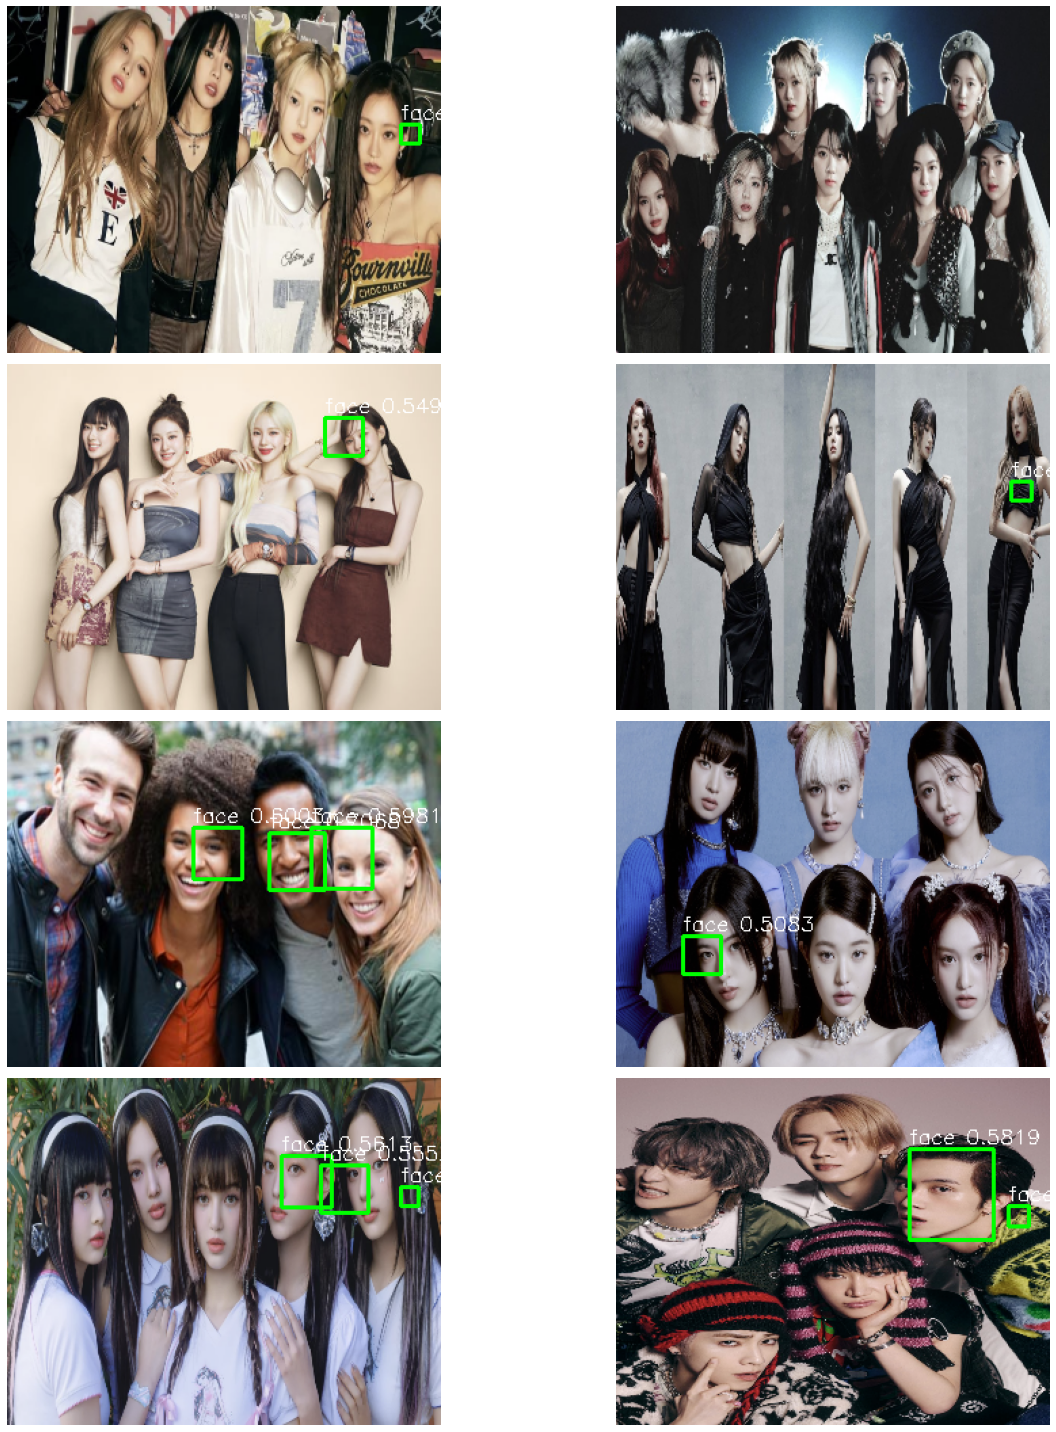

In [40]:
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
model2.load_weights(filepath)
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, f'pic{i}.png')

    img_raw = cv2.imread(TEST_IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(cf.cfg['steps']))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model2.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    if len(pred_boxes) > 0:
        pred_boxes = recover_pad(pred_boxes, pad_params)

        for box_index in range(len(pred_boxes)):
            draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)


    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
        
    axes[i//2,i%2].imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    axes[i//2,i%2].axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

## 문제점
* 노드에 있던 SSD 모델을 사용하여 Epoch 100을 놓고 훈련을 시킨 뒤 얼굴 탐지를 해본 결과 아예 얼굴을 잡지 못하기도하고, 눈 부분만을 얼굴로 인식하는 경우가 많은 것 같다.
* 이러한 문제로 인해 SSD 모델에 MobileNetV2를 사용하여 훈련을 시켜보려고 했다. 하지만 prediction의 shape을 (None, 4700, 5)으로 나와야지만 하기때문에 그 문제를 또 해결해야한다.

## 회고
#### 힘들었던 점: SSD face detection이 제대로 나오지 않아서 다른 모델을 만들었으나 shape이 맞지않아서 힘들었다.
#### 아쉬웠던 점: face detection이 제대로 되지 않아서 너무 아쉽다 계속 해봐야겠다
#### 배운점: SSD의 구조와 Yolo의 구조에 대해서 더 자세히 알게되었다. 또한 NMS의 알고리즘도 알게되었다.
#### 느낀점: 항상 노드에서 하라는대로 하면 좋은 결과를 얻지 못하는것같아서 어떻게 하면 더 좋은 face detection을 만들 수 있을지 더 생각하고 모델을 더 파헤쳐봐야겠다. 만약 이게 모델의 문제가 아니라 다른 문제라면 무엇인지도 더 자세히 알아봐야할것같다.